<a href="https://colab.research.google.com/github/isabelgilchristmiller/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [23]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [44]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [45]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [46]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [47]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [48]:
for i in range(0, Nt-1):
    T[i+1] = T[i] + dt *(F(t[i])-gamma*(T[i]-theta[i]))/(C_s)
    theta[i+1] = theta[i] + dt * (gamma*(T[i]-theta[i])/(C_d))

After you are finished, run the cell below to plot the results

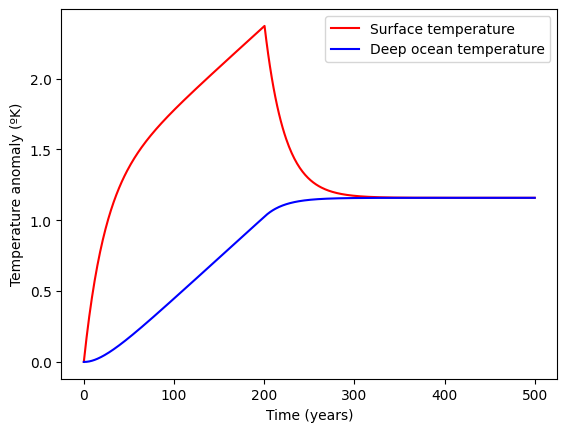

In [49]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change of the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain the response of T and θ to the forcing by defining characteristic timescales from the box model equations?

**At the start of the model run we can see that the temperature of the Earth's surface increases at a much faster rate than the temperature of the deep ocean. However, the rate of increase of the surface temperature starts to slow down earlier (at about 50-70 years) than the rate of increase of the ocean temperature which continues to increase. We can look at the start of the run numerically by examining the box model equations for when $T \sim 0$ and $\theta \sim 0$. For $F(t)=1$, this gives us the following:**

$$ \frac{\partial T}{\partial t} = \frac{1}{C_s} \text{ and } \frac{\partial \theta}{\partial t} = 0, $$

**which verifies that the surface ocean warms immediately but the deep ocean does not.**

**To define characteristic timescales, we can look at the box model equations. We calculate that the characteristic timescale for $T$ is $C_s/\gamma = 17/0.67 \simeq 25.37$ years and for $\theta$ it is $C_d/\gamma = 156/0.67 \simeq 232.84$ years. This means that we'd expect to see a significant change (of one e-folding time) in our system, on its way to equilibrium, roughly 25 years after the diffusion starts to occur for $T$ and after roughly 233 years for $\theta$.**

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

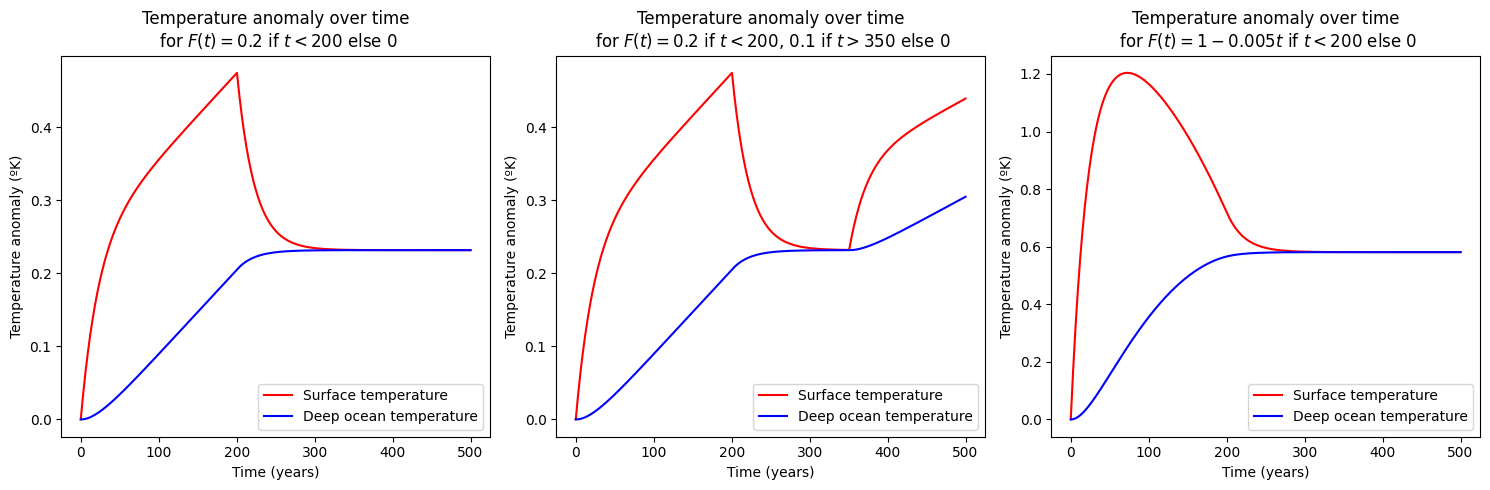

In [62]:
def F(t):
    return 0.2 if t < 200 else 0

# Reset T and theta arrays for the first scenario
#T = np.zeros(Nt)
#theta = np.zeros(Nt)
#T[0] = 0
#theta[0] = 0

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt *(F(t[i])-gamma*(T[i]-theta[i]))/(C_s)
    theta[i+1] = theta[i] + dt * (gamma*(T[i]-theta[i])/(C_d))

# Create a single figure to hold all subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(t,T,'r-')
axes[0].plot(t,theta,'b-')
axes[0].set_title('Temperature anomaly over time\n for $F(t)=0.2$ if $t < 200$ else $0$')
axes[0].legend(['Surface temperature','Deep ocean temperature'], loc='lower right')
axes[0].set_xlabel('Time (years)')
axes[0].set_ylabel('Temperature anomaly (ºK)')


def F(t):
    return 0.2 if t < 200 else 0.1 if t > 350 else 0

# Reset T and theta arrays for the second scenario
#T = np.zeros(Nt)
#theta = np.zeros(Nt)
#T[0] = 0
#theta[0] = 0

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt *(F(t[i])-gamma*(T[i]-theta[i]))/(C_s)
    theta[i+1] = theta[i] + dt * (gamma*(T[i]-theta[i])/(C_d))

axes[1].plot(t,T,'r-')
axes[1].plot(t,theta,'b-')
axes[1].set_title('Temperature anomaly over time\n for $F(t)=0.2$ if $t < 200$, $0.1$ if $t > 350$ else $0$')
axes[1].legend(['Surface temperature','Deep ocean temperature'], loc='lower right')
axes[1].set_xlabel('Time (years)')
axes[1].set_ylabel('Temperature anomaly (ºK)')


def F(t):
    return 1-0.005*t if t < 200 else 0

# Reset T and theta arrays for the third scenario
#T = np.zeros(Nt)
#theta = np.zeros(Nt)
#T[0] = 0
#theta[0] = 0

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt *(F(t[i])-gamma*(T[i]-theta[i]))/(C_s)
    theta[i+1] = theta[i] + dt * (gamma*(T[i]-theta[i])/(C_d))

axes[2].plot(t,T,'r-')
axes[2].plot(t,theta,'b-')
axes[2].set_title('Temperature anomaly over time\n for $F(t)=1-0.005t$ if $t < 200$ else $0$')
axes[2].legend(['Surface temperature','Deep ocean temperature'], loc='lower right')
axes[2].set_xlabel('Time (years)')
axes[2].set_ylabel('Temperature anomaly (ºK)')

plt.tight_layout()
plt.show()

**With forcing function F(t)=0.2 for t<200 we can see that we get the same shape of behaviour as the example above where we had F(t)=1. However, the temperature anomaly is scaled down accordingly (i.e. maximum surface temperature is ~0.5 instead of ~2.5). This shows that the behaviour of the ocean and surface temperatures is the same in both cases of F(t) and it is just the magnitude of the temperature anomaly that changes - this result carries for all F(t)=constant.**

**The second graph shows a case where for t<350 we have the same scenario as the first graph i.e. F(t)=0.2 for t<200 and then F(t)=0. However, instead of remaining with forcing function F(t)=0 for the rest of time, we instead have F(t)=0.1 for t>350. We can see in the graph that for t<350 we have the same behaviour as the first scenario. However, for t>350 both the surface and ocean temperatures have growth that starts as exponentials but then relaxes to a constant growth rate. We can see that although the temperature anomaly is not equal in the two cases, the rate of growth of the temperature anomaly is equal as the lines become parallel at around t~420.**

**The third graph shows a perhaps more realistic scenario, where we slowly decrease the amount of emissions over time (starting from t=0). This scenario is described by the forcing function F(t)=1-0.005t. We can see that rather than an abrupt decrease in the surface temperature anomaly at t=200 years, we see the surface temperature anomaly start decreasing much earlier at around t=70 years. Contrastingly, the ocean temperature anomaly actually increases slightly earlier (for very small t) than in the previous cases. The anomalies of both temperatures reach a steady state a bit earlier than the previous scenarious - this time around 250 years instead of 300 years.**

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [77]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [78]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    #print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [79]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    #print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [80]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic

Finally, define some parameters and the x and t vectors:

In [81]:
# Defining parameters
kappa = 0.02  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [82]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

and finally, plot the results side-by-side

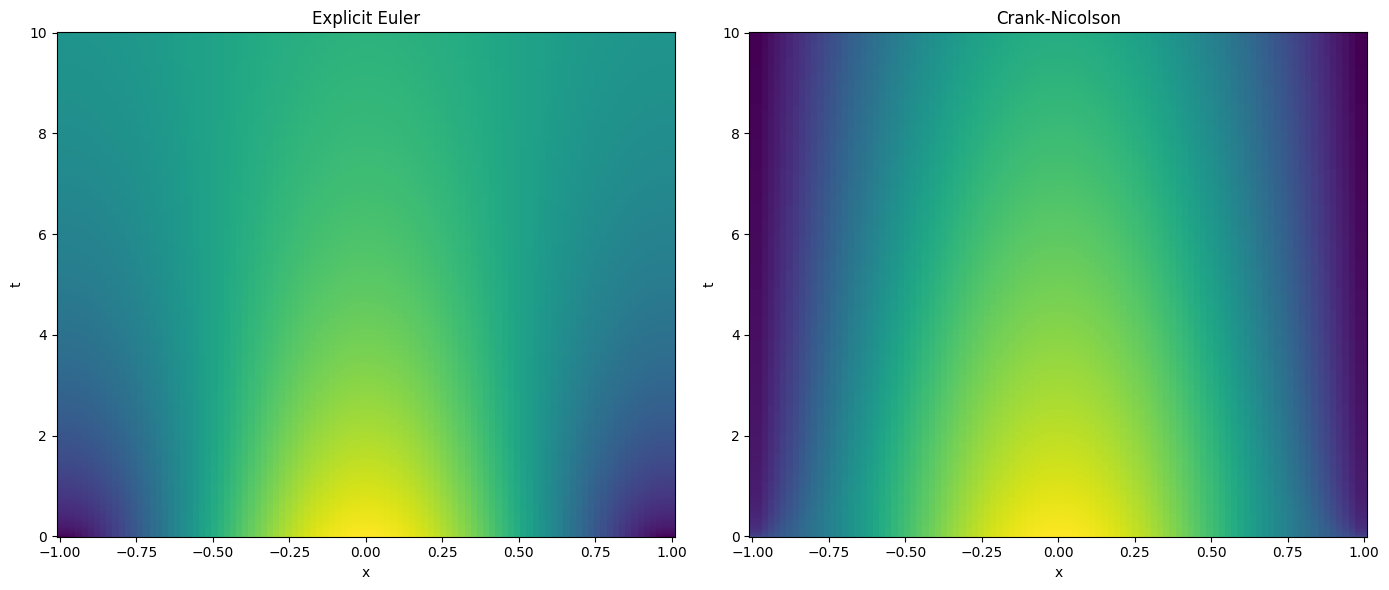

In [83]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

**We can see that as $\kappa$ increases, the explicit Euler method starts to exhibit an instability from $\kappa\sim 0.02$ where we see more diffusion than the Crank-Nicolson method. The instability becomes completely unstable at around $\kappa\sim 0.021$. We can calculate the stability condition of ($\Delta t \le \frac{\Delta x^2}{2\kappa}$), which verifies our observations (i.e. substitute $\Delta x = 0.02$ and $\Delta t = 0.01$).**

**The Crank-Nicolson method remains stable for higher levels of diffusivity $\kappa$ (it is in fact unconditionally stable). When $\kappa$ gets large enough, this is actually quite unrealistic. It is possible that this is a simplification of the approximation/model to keep it under control, because the more realistic scenario of large diffusion for large $\kappa$ would break the model.**

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

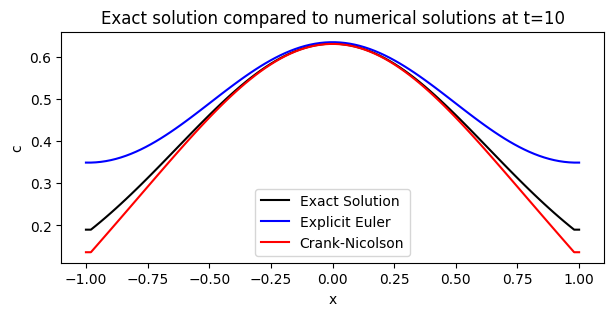

In [84]:
# Add code to plot exact and numerical solutions

kappa = 0.01

# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

plt.figure(figsize=(7, 3))
plt.plot(x, set_ics(x, kappa, 20), color='black', label='Exact Solution') # note we run at t=20=10+10 because the function start from 10
plt.plot(x, c_EE[:,-1], color='blue', label='Explicit Euler')
plt.plot(x, c_CN[:,-1], color='red', label='Crank-Nicolson')
plt.legend()

plt.xlabel('x')
plt.ylabel('c')
plt.title('Exact solution compared to numerical solutions at t=10')

plt.show()

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

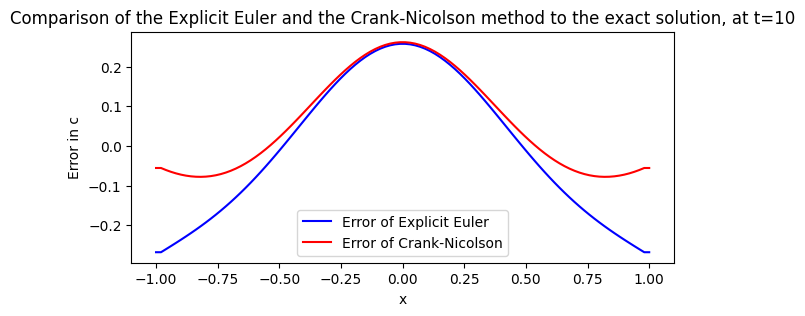

In [85]:
# Add code to plot error here

kappa = 0.01

# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

plt.figure(figsize=(7, 3))

plt.plot(x, set_ics(x, kappa, 10) - c_EE[:,-1], color='blue', label='Error of Explicit Euler')
plt.plot(x, set_ics(x, kappa, 10) - c_CN[:,-1], color='red', label='Error of Crank-Nicolson')
plt.legend()
plt.xlabel('x')
plt.ylabel('Error in c')
plt.title('Comparison of the Explicit Euler and the Crank-Nicolson method to the exact solution, at t=10')

plt.show()

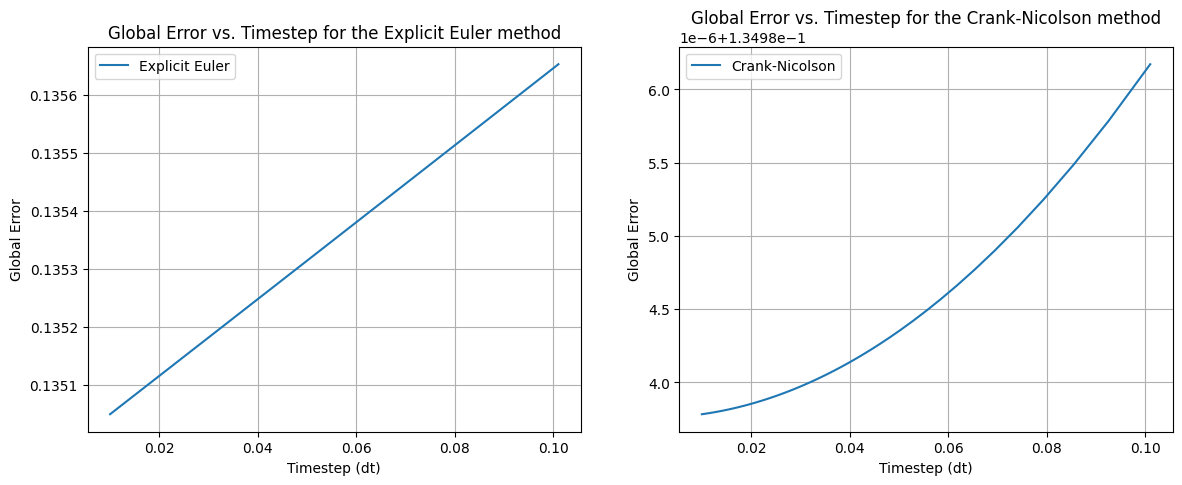

In [92]:
kappa = 0.001

Nt_values_raw = np.linspace(100, 1000, 100)
Nt_values = [int(nt) for nt in Nt_values_raw if int(nt) >= 2]

ee_errors = []
cn_errors = []
dt_values = []

for i, Nt in enumerate(Nt_values):
    t = np.linspace(t_start, t_end, Nt)

    dt = t[1] - t[0]
    dt_values.append(dt)

    c_EE = EE(x, t, kappa) # explicit Euler
    c_CN = CN(x, t, kappa) # Crank-Nicolson

    exact_solution_at_tend = set_ics(x, kappa, t_end)
    xpoint = 40

    ee_error = abs(c_EE[xpoint, -1] - exact_solution_at_tend[xpoint])
    cn_error = abs(c_CN[xpoint, -1] - exact_solution_at_tend[xpoint])

    ee_errors.append(ee_error)
    cn_errors.append(cn_error)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(dt_values, ee_errors, label='Explicit Euler')
plt.xlabel('Timestep (dt)')
plt.ylabel('Global Error')
plt.title('Global Error vs. Timestep for the Explicit Euler method')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(dt_values, cn_errors, label='Crank-Nicolson')
plt.xlabel('Timestep (dt)')
plt.ylabel('Global Error')
plt.title('Global Error vs. Timestep for the Crank-Nicolson method')
plt.legend()
plt.grid(True)

plt.show()

**The left hand graph shows that the explicit Euler method is 1st order accurate, since it has a linear shape. The right hand graph shows that the Crank-Nicolson method is 2nd order accurate, since it has a quadratic shape (note that to check this you could plot it on a logarithmic scale and see the linear graph with gradient 2). These results align with our preconceptions about the methods.**

**I think it is worth noting that getting these clearly visible results required specific choices of $dt$ and $x$ and $\kappa$. For example, a small $\kappa=0.001$ was required. Also, a value of $x$ away from the boundaries or the center gave the most obvious results.**

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

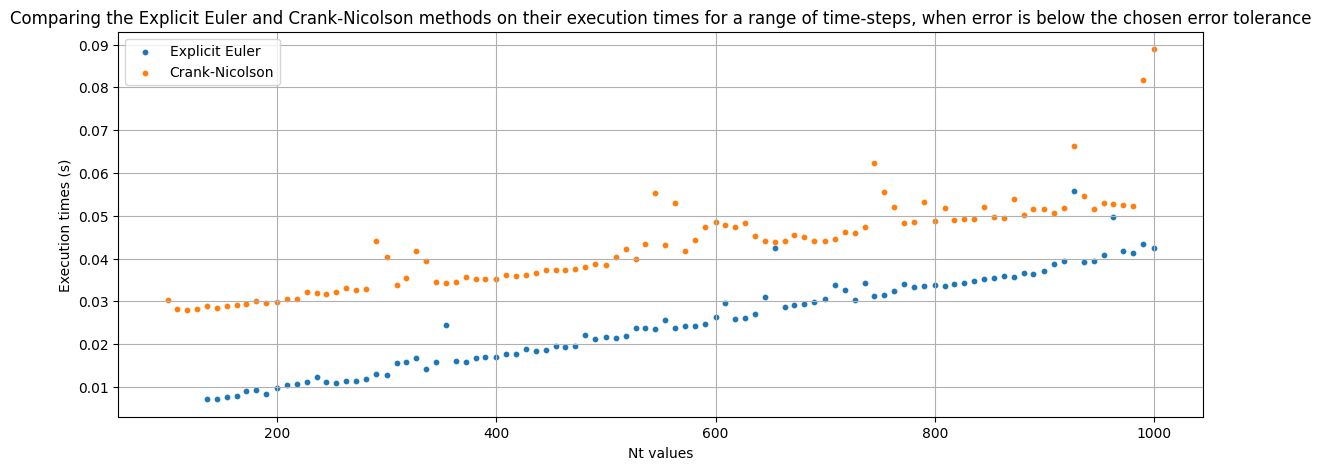

In [93]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # Ignore all warnings

Nt_values_df = pd.DataFrame({'Nt': Nt_values})
dt_values_df = pd.DataFrame({'dt': dt_values})
ee_errors_df = pd.DataFrame({'ee': ee_errors})
cn_errors_df = pd.DataFrame({'cn': cn_errors})

dt_and_ee_df = pd.concat([Nt_values_df, dt_values_df, ee_errors_df], axis=1)
dt_and_cn_df = pd.concat([Nt_values_df, dt_values_df, cn_errors_df], axis=1)

error_tolerance = 0.1355
ee_below_error_tolerance_df = dt_and_ee_df[(dt_and_ee_df['ee'] <= error_tolerance)]
cn_below_error_tolerance_df = dt_and_cn_df[(dt_and_cn_df['cn'] <= error_tolerance)]

ee_execution_times = []
cn_execution_times = []

for Nt_val in ee_below_error_tolerance_df['Nt']:
    t_running = np.linspace(t_start, t_end, Nt_val)
    start_time_ee = time.time()
    EE(x, t_running, kappa)
    end_time_ee = time.time()
    ee_execution_times.append(end_time_ee - start_time_ee)

for Nt_val in cn_below_error_tolerance_df['Nt']:
    t_running = np.linspace(t_start, t_end, Nt_val)
    start_time_cn = time.time()
    CN(x, t_running, kappa)
    end_time_cn = time.time()
    cn_execution_times.append(end_time_cn - start_time_cn)

ee_below_error_tolerance_df['ee_execution_time'] = ee_execution_times
cn_below_error_tolerance_df['cn_execution_time'] = cn_execution_times

plt.figure(figsize=(14, 5))

plt.scatter(ee_below_error_tolerance_df['Nt'], ee_below_error_tolerance_df['ee_execution_time'], s=10, label='Explicit Euler')
plt.scatter(cn_below_error_tolerance_df['Nt'], cn_below_error_tolerance_df['cn_execution_time'], s=10, label='Crank-Nicolson')
plt.legend()
plt.xlabel('Nt values')
plt.ylabel('Execution times (s)')
plt.title('Comparing the Explicit Euler and Crank-Nicolson methods on their execution times for a range of time-steps, when error is below the chosen error tolerance')
plt.grid(True)

plt.show()

**I have plotted the execution times of the explicit Euler and Crank-Nicolson simulations that had error below the chosen error tolerance (0.1355 in the plot), for a range of timesteps. The graph clearly shows that the explicit Euler method is more efficient than the Crank-Nicolson method, which is what we would expect.**

**Also as expected, there is a general linear relationship between execution time and the Nt values. Although some anomalies to this linear relationship can be seen, it tends to be the case that even the anomalies of the explicit Euler method still have faster execution times than the Crank-Nicolson method (in the majority of cases).**

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

**To correct the matrix to account for the homogenous Neumann boundary conditions, the first and last rows need to be edited. To ensure that the finite difference method holds, we need the sum of the elements in the first row to be zero (and the same for the last row). Therefore, it can be calculated that we need to correct our matrix to be as follows:**

$M = \begin{pmatrix}
-1 & 1 & 0 & ... & ... & ... & 0\\
1 & -2 & 1 & 0 & ... & ... & 0\\
0 & 1 & -2 & 1 & 0 & ... & 0\\
. &&&&&& .\\
. &&&&&& .\\
0 & ... & ... & ... & ... & 1 & -1
\end{pmatrix}.$

**This is what I've modified in the code below, to make it differ from the function $CN(x, t, \kappa)$ above. Note that an alternative form of the matrix would be the following:**

$M = \begin{pmatrix}
-2 & 2 & 0 & ... & ... & ... & 0\\
1 & -2 & 1 & 0 & ... & ... & 0\\
0 & 1 & -2 & 1 & 0 & ... & 0\\
. &&&&&& .\\
. &&&&&& .\\
0 & ... & ... & ... & ... & 2 & -2
\end{pmatrix}.$

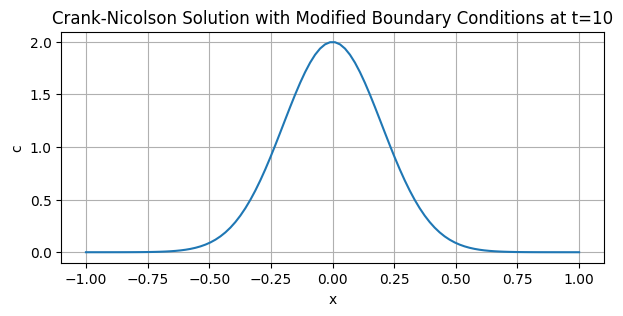

Gradient at left boundary = 0.0
Gradient at right boundary = 0.0


In [104]:
def CN_neumann_bc(x, t, kappa):
    start_time = time.time()

    dt = t[1] - t[0]

    M = construct_M(x)
    Nx = len(x)
    Nt = len(t)

    dx = x[1] - x[0]
    M[0, 0] = -1.0 / dx**2
    M[0, 1] = 1.0 / dx**2
    M[Nx-1, Nx-1] = -1.0 / dx**2
    M[Nx-1, Nx-2] = 1.0 / dx**2

    A = sp.eye(Nx) - 0.5 * dt * kappa * M
    A_inv = spla.inv(A)

    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)

    for k in range(1, Nt):
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()

    return c

c_CN_modified = CN_neumann_bc(x, t, kappa)

plt.figure(figsize=(7, 3))
plt.plot(x, c_CN_modified[:,-1], label='Crank-Nicolson with Modified BC')
plt.xlabel('x')
plt.ylabel('c')
plt.title('Crank-Nicolson Solution with Modified Boundary Conditions at t=10')
plt.grid(True)
plt.show()

print(f"Gradient at left boundary = {(c_CN_modified[1, -1] - c_CN_modified[0, -1]) / (x[1] - x[0])}")
print(f"Gradient at right boundary = {(c_CN_modified[-1, -1] - c_CN_modified[-2, -1]) / (x[-1] - x[-2])}")

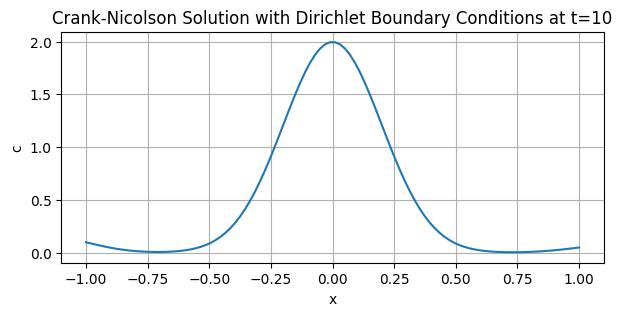

Value at left boundary = 0.1
Value at right boundary = 0.05


In [105]:
def CN_dirichlet_bc(x, t, kappa, c_left, c_right):
    start_time = time.time()

    dt = t[1] - t[0]

    M = construct_M(x)
    Nx = len(x)
    Nt = len(t)

    M_interior = M[1:-1, 1:-1]
    Nx_interior = Nx - 2

    A_interior = sp.eye(Nx_interior) - 0.5 * dt * kappa * M_interior
    A_interior_inv = spla.inv(A_interior)

    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)
    c[0, 0] = c_left
    c[-1, 0] = c_right

    for k in range(1, Nt):
        rhs_interior = c[1:-1, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1])[1:-1]

        rhs_interior[0] = rhs_interior[0] + (0.5 * dt * kappa * M[1, 0] * c_left)
        rhs_interior[-1] = rhs_interior[-1] + (0.5 * dt * kappa * M[Nx-2, Nx-1] * c_right)

        c[1:-1, k] = A_interior_inv @ rhs_interior
        c[0, k] = c_left
        c[-1, k] = c_right

    end_time = time.time()
    return c

c_left_bc = 0.1
c_right_bc = 0.05

c_CN_dirichlet = CN_dirichlet_bc(x, t, kappa, c_left_bc, c_right_bc)

plt.figure(figsize=(7, 3))
plt.plot(x, c_CN_dirichlet[:,-1], label='Crank-Nicolson with Dirichlet BC')
plt.xlabel('x')
plt.ylabel('c')
plt.title('Crank-Nicolson Solution with Dirichlet Boundary Conditions at t=10')
plt.grid(True)
plt.show()

print(f"Value at left boundary = {c_CN_dirichlet[0, -1]}")
print(f"Value at right boundary = {c_CN_dirichlet[-1, -1]}")

ADD DISCUSSION OF DIRICHLET AND NEUMANN BOUNDARY CONDITIONS HERE (NO CODE NEEDED)

** *[Note that most of my discussion is above]* **

**Homogeneous Neumann boundary conditions require $\partial_x c(0)=0$ and $\partial_x c(L)=0$, which have been implemented and discussed above. There is also code to manually check that the gradient at both boundaries is 0, which it is as expected.**

**Generalised Dirichlet conditions require $c(0)=a$ and $c(L)=b$. In the above example I chose $c(a)=0.1$ and $c(L)=0.05$. While this can visually be seen in the plots I have also checked it manually, as can be in the code.**